# BLISS walkthrough

The following steps are shown in this notebook:

0. install dependencies
1. load file from disk
2. visualize data before any manipulation (rough sanity check we're interpreting files correctly)
3. set mask bits using various flaggers (spectral kurtosis and filter roll-off)
4. estimate noise statistics (noise floor + noise power)
5. integrate along different drift rates
6. :-|

In [1]:
# These are always good to have loaded and ipympl makes the interactive plots work

!pip install numpy matplotlib ipympl
# h5py hdf5plugin  scipy



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


The following will assume this is in something like the "notebooks" folder inside bliss, and everything is already built in the `build/` directory of bliss

In [2]:
import sys
if "../build/bliss/python" not in sys.path:
    sys.path.append("../build/bliss/python/")
import pybliss

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

# don't need these where we're going!
# import h5py
# import hdf5plugin

Set these locations and paths according to specific data to look at...

In [3]:
data_loc = "/home/nathan/datasets/voyager_2020_data/"
test_file = f"{data_loc}/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5"


In [4]:
!ls {data_loc}

single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat
single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5
single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.log
single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.dat
single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5
single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.log
single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.dat
single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5
single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.log
single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.dat
single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5
single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.log
single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.dat
single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5
single_coarse_guppi_59046_81310_DIAG_VO

In [5]:
cadence = pybliss.cadence([[f"{data_loc}/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5",
                    f"{data_loc}/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5",
                    f"{data_loc}/single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5"
                    ],
                    [f"{data_loc}/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5"],
                    [f"{data_loc}/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5"],
                    [f"{data_loc}/single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016.rawspec.0000.h5"]])

In [6]:
help(cadence)

print(cadence.observations[0].filterbanks[0].src_dej)
print(cadence.observations[0].filterbanks[0].src_raj)

print(cadence.observations[1].filterbanks[0].src_dej)
print(cadence.observations[1].filterbanks[0].src_raj)

print(cadence.observations[0].filterbanks[1].src_dej)
print(cadence.observations[0].filterbanks[1].src_raj)


Help on cadence in module pybliss object:

class cadence(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self, arg: list[pybliss.observation_target], /) -> None
 |      __init__(self, arg: list[list[str]], /) -> None
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from nanobind.nb_type_0
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  observations
 |      (self) -> list[pybliss.observation_target]

12.403781666666667
17.211244722222222
13.403784444444447
17.211244999999998
12.403793333333335
17.211244999999998


In [7]:


flagged_cadence = pybliss.flaggers.flag_filter_rolloff(cadence, .2)

flagged_cadence = pybliss.flaggers.flag_spectral_kurtosis(flagged_cadence, .02, 5)



spec kurtosis with M=16 and N=51
spec kurtosis with M=16 and N=51
spec kurtosis with M=16 and N=51
spec kurtosis with M=16 and N=51
spec kurtosis with M=16 and N=51
spec kurtosis with M=16 and N=51


6715088
(16, 1048576)


/home/nathan/quadraturedev/customers/seti/bliss/.venv/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/nathan/quadraturedev/customers/seti/bliss/.venv/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


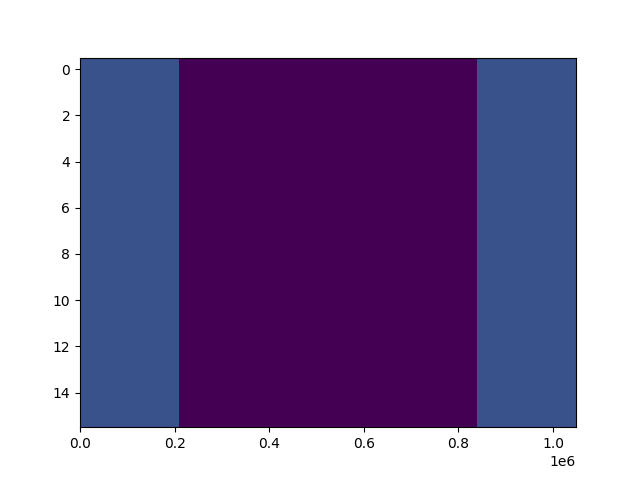

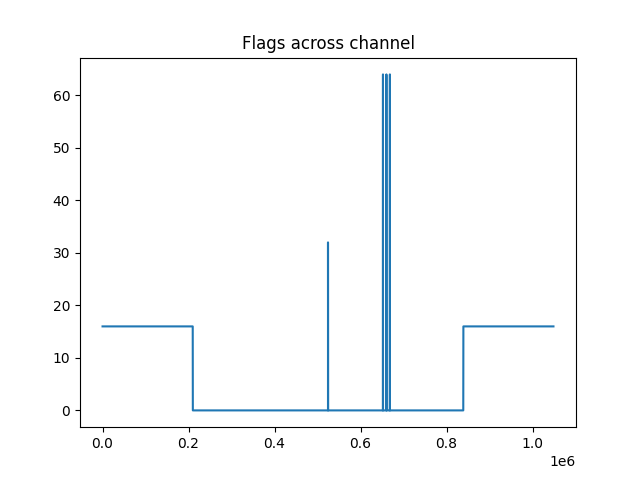

In [8]:
mask = np.from_dlpack(flagged_cadence.observations[0].filterbanks[1].mask)

print(mask.sum())
print(mask.shape)

plt.figure()
plt.imshow(mask, aspect="auto", interpolation="none")

plt.figure()
plt.title("Flags across channel")
plt.plot(mask.sum(0))

In [9]:
plot_filterbank = flagged_cadence.observations[0].filterbanks[0]
data_arr = np.array(np.from_dlpack(plot_filterbank.data))


noise_est_slice = data_arr[:, int(2.2e5):int(4e5)]

print(f"noise floor of cropped spectrum: {np.mean(noise_est_slice/1e6)}")
print(f"noise power of cropped spectrum: {np.var(noise_est_slice)/1e6:1.4e}")


noise_est_options = pybliss.estimators.noise_power_estimate_options()
noise_est_options.masked_estimate = False
noise_est_options.estimator_method = pybliss.estimators.noise_power_estimator.stddev
noise_est = pybliss.estimators.estimate_noise_power(noise_est_slice, noise_est_options)
print(noise_est.noise_floor)
print(noise_est.noise_power)



noise floor of cropped spectrum: 5.504250526428223
noise power of cropped spectrum: 3.1901e+05
5503724.0
319008571392.0


In [10]:
noise_est_options = pybliss.estimators.noise_power_estimate_options()
noise_est_options.masked_estimate = False
noise_est_options.estimator_method = pybliss.estimators.noise_power_estimator.stddev
flagged_cadence = pybliss.estimators.estimate_noise_power(flagged_cadence, noise_est_options)

noise_stats = flagged_cadence.observations[0].filterbanks[0].noise_estimates

print(f"noise floor of spectrum (estimated without rfi mask): \t{noise_stats.noise_floor/1e6:1.4f}")
print(f"noise power of spectrum (estimated without rfi mask): \t{noise_stats.noise_power/1e6:1.4e}")
print("---")

noise_est_options = pybliss.estimators.noise_power_estimate_options()
noise_est_options.masked_estimate = True
noise_est_options.estimator_method = pybliss.estimators.noise_power_estimator.stddev
flagged_cadence = pybliss.estimators.estimate_noise_power(flagged_cadence, noise_est_options)

noise_stats = flagged_cadence.observations[0].filterbanks[0].noise_estimates

print(f"noise floor of spectrum (estimated with rfi mask): \t{noise_stats.noise_floor/1e6:1.4f}")
print(f"noise power of spectrum (estimated with rfi mask): \t{noise_stats.noise_power/1e6:1.4e}")
print("---")

# noise_est_options = pybliss.estimators.noise_power_estimate_options()
# noise_est_options.masked_estimate = False
# noise_est_options.estimator_method = pybliss.estimators.noise_power_estimator.mad
# flagged_cadence = pybliss.estimators.estimate_noise_power(flagged_cadence, noise_est_options)

# noise_stats = flagged_cadence.observations[0].filterbanks[0].noise_estimates

# print(f"noise floor of spectrum (estimated without rfi mask using MAD): \t{noise_stats.noise_floor/1e6:1.4f}")
# print(f"noise power of spectrum (estimated without rfi mask using MAD): \t{noise_stats.noise_power/1e6:1.4e}")
# print("---")


noise floor of spectrum (estimated without rfi mask): 	5.1027
noise power of spectrum (estimated without rfi mask): 	1.2485e+07
---
noise floor of spectrum (estimated with rfi mask): 	5.1838
noise power of spectrum (estimated with rfi mask): 	4.0285e+06
---


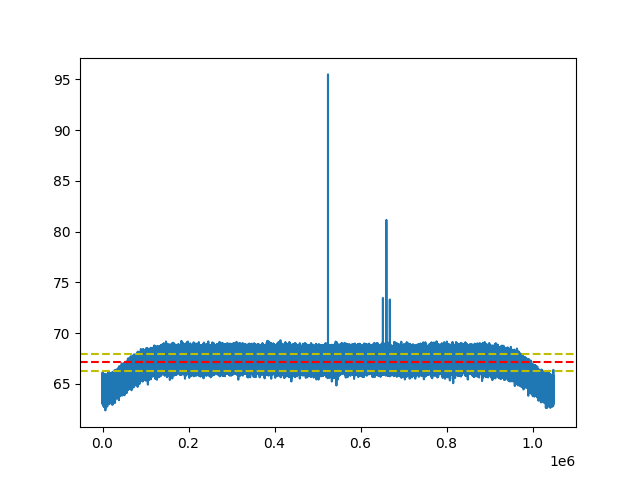

In [11]:

cad_plot = 0
obs_plot = 0

plot_filterbank = flagged_cadence.observations[cad_plot].filterbanks[obs_plot]
plot_data = np.from_dlpack(plot_filterbank.data)
plt.figure()

# for r in range(plot_data.shape[0]):
r = 10
_ = plt.plot(10*np.log10(plot_data[r,:]))

_ = plt.axhline(y=10*np.log10(plot_filterbank.noise_estimates.noise_floor), color='r', linestyle='--')
_ = plt.axhline(y=10*np.log10(plot_filterbank.noise_estimates.noise_floor-plot_filterbank.noise_estimates.noise_amplitude/2), color='y', linestyle='--')
_ = plt.axhline(y=10*np.log10(plot_filterbank.noise_estimates.noise_floor+plot_filterbank.noise_estimates.noise_amplitude/2), color='y', linestyle='--')


In [12]:
opts = pybliss.integrate_drifts_options()
opts.desmear = False
opts.low_rate = -32
opts.high_rate = 48
opts.rate_step_size = 1


dedrift = pybliss.drift_search.integrate_drifts(flagged_cadence.observations[0].filterbanks[0], opts)

# TODO: with desmear = True, there's an error in addition

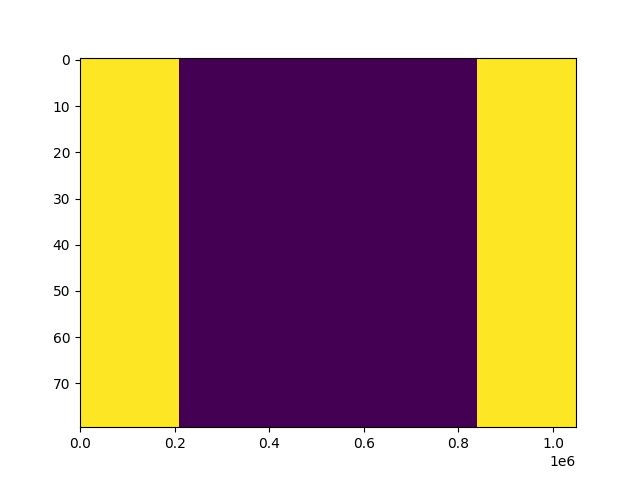

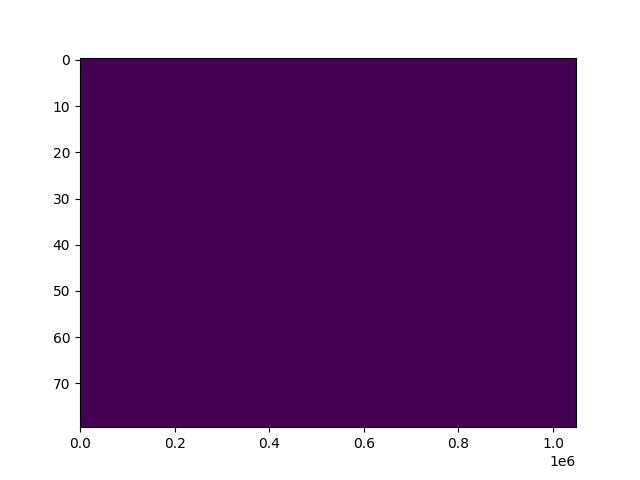

In [13]:

rolloff = np.from_dlpack(dedrift.dedrifted_rfi().filter_rolloff)

plt.figure()
plt.imshow(rolloff, aspect="auto", interpolation="none")


low_sk = np.from_dlpack(dedrift.dedrifted_rfi().low_spectral_kurtosis)
plt.figure()
plt.imshow(low_sk, aspect="auto", interpolation="none")


In [14]:
det_plane_with_smear_correction = np.from_dlpack(dedrift.dedrifted_spectrum())

print(det_plane_with_smear_correction.shape)

(80, 1048576)


In [34]:
## This is a demo of calling the hit searches manually to compare/contrast the hit search process itself

# search_opts = pybliss.drift_search.hit_search_options()
# search_opts.method = pybliss.drift_search.hit_search_methods.local_maxima
# neighborhood = [[-1, 0], [1, 0],   [0, -1], [0, 1],
#                 [1, 1], [-1, -1],  [-1, 1], [1, -1],
#                 [-2, 0], [2, 0],   [0, 2], [0, -2]]
# components = pybliss.drift_search.find_local_maxima_above_threshold(dedrift, noise_stats, 10.0, neighborhood)

# connected_components = pybliss.drift_search.find_components_above_threshold(dedrift, noise_stats, 10.0, neighborhood)



In [35]:
# print(f"local maxima above threshold found {len(components)}")
# print(f"connected components above threshold found {len(connected_components)}")
# With 4-neighborhood: 15756
# With 8-neighborhood: 15756

# Local max:
# With 4-neighborhood: 2461
# With 8-neighborhood: 1128
# With 12-neighborhood: 822

# Connected components: 52

In [33]:
hit_search_opts = pybliss.drift_search.hit_search_options()
hit_search_opts.method = pybliss.drift_search.hit_search_methods.local_maxima
hit_search_opts.snr_threshold = 10.0

hits = pybliss.drift_search.hit_search(dedrift, noise_stats, hit_search_opts)

for h in hits:
    print(f"hit at F={h.start_freq_MHz:4.3f} MHz drifting at {h.drift_rate_Hz_per_sec:.3f} Hz/sec with SNR={h.snr:2.1f} and BW={h.bandwidth} rfi counts={h.rfi_counts}")



local_maxima looking through 83886080 candidates with threshold 8.35733e+06
hit at F=8419.922 MHz drifting at 0.306 Hz/sec with SNR=48197.6 and BW=0 rfi counts={pybliss.flaggers.flag_values.filter_rolloff: 0, pybliss.flaggers.flag_values.low_spectral_kurtosis: 1, pybliss.flaggers.flag_values.high_spectral_kurtosis: 0, pybliss.flaggers.flag_values.magnitude: 0, pybliss.flaggers.flag_values.sigma_clip: 0}
hit at F=8419.922 MHz drifting at 0.306 Hz/sec with SNR=47538.9 and BW=0 rfi counts={pybliss.flaggers.flag_values.filter_rolloff: 0, pybliss.flaggers.flag_values.low_spectral_kurtosis: 1, pybliss.flaggers.flag_values.high_spectral_kurtosis: 0, pybliss.flaggers.flag_values.magnitude: 0, pybliss.flaggers.flag_values.sigma_clip: 0}
hit at F=8419.922 MHz drifting at 0.306 Hz/sec with SNR=49452.7 and BW=0 rfi counts={pybliss.flaggers.flag_values.filter_rolloff: 0, pybliss.flaggers.flag_values.low_spectral_kurtosis: 1, pybliss.flaggers.flag_values.high_spectral_kurtosis: 0, pybliss.flaggers.f